In [115]:
import os
import pandas as pd
import sys
import seaborn as sns
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from creds import getCensusAPI

path = os.path.abspath('')


In [116]:
#Load raw tract-wise data
fcc_path = path+'\\static-data\\cleaned_fcc_tracts.csv'

fcc_data = pd.read_csv(fcc_path)

fcc_data.drop(['Unnamed: 0'], axis=1, inplace=True)

fcc_data['state'] = fcc_data['state'].astype(str).str.zfill(2)
fcc_data['tract'] = fcc_data['tract'].astype(str).str.zfill(6)
fcc_data['county'] = fcc_data['county'].astype(str).str.zfill(3)

fcc_data.describe()

,Max Advertised Downstream Speed (mbps),Percentage Access
count,72987.000000,72987.000000
mean,838.148725,0.856818
std,725.073403,0.255014
min,2.000000,0.000000
25%,940.000000,0.818182
50%,1000.000000,1.000000
75%,1000.000000,1.000000
max,10000.000000,1.000000


In [117]:
#Current threshold = 50mbps, further narrow down if needed, add labels to blocks
threshold = 50

fcc_data['Access'] = np.nan
fcc_data['Access'][fcc_data['Max Advertised Downstream Speed (mbps)'] >= threshold] = 1
fcc_data['Access'][fcc_data['Max Advertised Downstream Speed (mbps)'] < threshold] = 0

C:\Users\Jude\AppData\Local\Temp\ipykernel_23048\1412316767.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcc_data['Access'][fcc_data['Max Advertised Downstream Speed (mbps)'] >= threshold] = 1
C:\Users\Jude\AppData\Local\Temp\ipykernel_23048\1412316767.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcc_data['Access'][fcc_data['Max Advertised Downstream Speed (mbps)'] < threshold] = 0


In [118]:
print('{}% of census tracts lack access to sufficient internet speeds'.format(round((fcc_data['Access'].value_counts()[0]/len(fcc_data['Access']))*100,2)))

9.71% of census tracts lack access to sufficient internet speeds


https://api.census.gov/data/2020/acs/acs5/variables.html

In [119]:
cols = {
    #Population
    'B01003_001E':'Total',
    #Sex
    'B01001_002E':'Total Male',
    'B01001_026E':'Total Female',
    #Age
    'B01002_001E': 'Median Age',
    'B01002_002E': 'Median Age Male',
    'B01002_003E': 'Median Age Female',
    'B29001_002E': '18 to 29 years',
    'B29001_003E': '30 to 44 years',
    'B29001_004E': '45 to 64 years',
    'B29001_005E': '65 years and over',
    #Race 
    'C02003_003E': 'White',
    'C02003_004E': 'Black or African American',
    'C02003_005E': 'American Indian and Alaska Native',
    'C02003_006E': 'Asian',
    'C02003_007E': 'Native Hawaiian and Other Pacific Islander',
    'C02003_008E': 'Some other race',
    'C02003_009E': 'Two or more races',
    'C02003_010E': 'Two or more including some other race',
    'C02003_011E': 'Two or more excluding some other race, and three or more',
    'B03001_003E': 'Hispanic or Latino',
    #Citizenship
    'B05001_006E': 'Not a Citizen',
    #Birth
    'B05012_002E': 'Native',
    'B05012_003E': 'Foreign Born',
    #English and language proficiency
    'B06007_002E': 'Speak only English',
    'B06007_003E': 'Speak Spanish',
    'B06007_004E': 'Speak Spanish, English very well',
    'B06007_005E': 'Speak Spanish, English less than very well',
    'B06007_006E': 'Speak other languages',
    'B06007_007E': 'Speak other language, English very well',
    'B06007_008E': 'Speak other language, English less than very well',
    #Individual income
    'B06010_002E': 'No individual income (12mo)',
    'B06010_003E': 'With individual income (12mo)',
    'B06010_004E': 'Less than 10000 individual income (12mo)',
    'B06010_005E': '10000 - 14999 individual income (12mo)',
    'B06010_006E': '15000 - 24999 individual income (12mo)',
    'B06010_007E': '25000 - 34999 individual income (12mo)',
    'B06010_008E': '35000 - 49999 individual income (12mo)',
    'B06010_009E': '50000 - 64999 individual income (12mo)',
    'B06010_010E': '65000 - 74999 individual income (12mo)',
    'B06010_011E': '75000 or more individual income (12mo)',
    'B06011_001E': 'Median individual income (12mo)',
    #Poverty level comparisons
    'B05010_002E': 'Ratio of income to poverty < 1.00',
    'B05010_010E': 'Ratio of income to poverty 1.00 to 1.99',
    'B05010_018E': 'Ratio of income to poverty > 1.99',
    'B06012_002E': 'Below 100% of poverty level',
    'B06012_003E': '100 to 149% of poverty level',
    'B06012_004E': 'At or above 150% of poverty level',
}

In [120]:
cols2 = {
    #Education
    'B07009_002E': 'Less than High School',
    'B06009_003E': 'High School Grad',
    'B06009_004E': 'Some college or associate degree',
    'B06009_005E': 'Bachelor',
    'B06009_006E': 'Graduate or professional degree',
    #Educational Attainment for 25 and over
    'B15003_002E': 'No schooling completed (25 and over)',
    'B15003_003E': 'Nursery (25 and over)',
    'B15003_004E': 'Kindergarten (25 and over)',
    'B15003_005E': '1st grade (25 and over)',
    'B15003_006E': '2nd grade (25 and over)',
    'B15003_007E': '3rd grade (25 and over)',
    'B15003_008E': '4th grade (25 and over)',
    'B15003_009E': '5th grade (25 and over)',
    'B15003_010E': '6th grade (25 and over)',
    'B15003_011E': '7th grade (25 and over)',
    'B15003_012E': '8th grade (25 and over)',
    'B15003_013E': '9th grade (25 and over)',
    'B15003_014E': '10th grade (25 and over)',
    'B15003_015E': '11th grade (25 and over)',
    'B15003_016E': '12th grade no diploma (25 and over)',
    'B15003_017E': 'HS Diploma (25 and over)',
    'B15003_018E': 'GED or alternative (25 and over)',
    'B15003_019E': 'Some college, less than 1 year (25 and over)',
    'B15003_020E': 'Some college, 1 or more years no degree (25 and over)',
    'B15003_021E': 'Associate degree',
    'B15003_022E': 'Bachelor degree',
    'B15003_023E': 'Masters degree',
    'B15003_024E': 'Professional school degree',
    'B15003_025E': 'Doctorate degree',
    #Labor
    'B23025_002E': 'In labor force',
    'B23025_007E': 'Not in labor force',
    'B23020_001E': 'Mean usual hours worked',
    'B08122_025E': 'Worked from home',
    #Occupation
    'B08124_002E': 'Management, business, science, and arts',
    'B08124_003E': 'Service occupations',
    'B08124_004E': 'Sales and office occupations',
    'B08124_005E': 'Natural resources, construction, and maintenance occupations',
    'B08124_006E': 'Production, transportation, and material moving occupations',
    'B08124_007E': 'Military specific occupations',
}

In [121]:
cols3 = {
    #Industry
    'B08126_002E': 'Agriculture, forestry, fishing, hunting, mining',
    'B08126_003E': 'Construction',
    'B08126_004E': 'Manufacturing',
    'B08126_005E': 'Wholesale trade',
    'B08126_006E': 'Retail trade',
    'B08126_007E': 'Transportation and warehousing, and utilities',
    'B08126_008E': 'Information',
    'B08126_009E': 'Finance and insurance, and real estate and rental and leasing',
    'B08126_010E': 'Professional, scientific, and management, and administrative and waste management services',
    'B08126_011E': 'Educational services, and health care and social assistance',
    'B08126_012E': 'Arts, entertainment, and recreation, and accommodation and food services',
    'B08126_013E': 'Other services (except public administration)',
    'B08126_014E': 'Public administration',
    'B08126_015E': 'Armed forces',
    #Inequality
    'B19083_001E': 'Gini Index',
    'B19081_006E': 'Top 5 percent mean income',
    'B19082_006E': 'Top 5 percent income share',
    'B19082_005E': 'Income share of highest quintile',
    #Other income streams
    'B19054_002E': 'With interest, rent, dividend',
    'B19055_002E': 'With social security income',
    'B19056_002E': 'With supplement security income (SSI)',
    'B19057_002E': 'With public assistance income',
    'B19058_002E': 'With public assistance income or food stamps',
    #Family income
    'B19101_002E': 'Family income <10000 (12mo)',
    'B19101_003E': 'Family income 10000 - 14999 (12mo)',
    'B19101_004E': 'Family income 14000 - 19999 (12mo)',
    'B19101_005E': 'Family income 20000 - 24999 (12mo)',
    'B19101_006E': 'Family income 25000 - 29999 (12mo)',
    'B19101_007E': 'Family income 30000 - 34999 (12mo)',
    'B19101_008E': 'Family income 35000 - 39999 (12mo)',
    'B19101_009E': 'Family income 40000 - 44999 (12mo)',
    'B19101_010E': 'Family income 45000 - 49999 (12mo)',
    'B19101_011E': 'Family income 50000 - 59999 (12mo)',
    'B19101_012E': 'Family income 60000 - 74999 (12mo)',
    'B19101_013E': 'Family income 75000 - 99999 (12mo)',
    'B19101_014E': 'Family income 100000 - 124999 (12mo)',
    'B19101_015E': 'Family income 125000 - 149999 (12mo)',
    'B19101_016E': 'Family income 150000 - 199999 (12mo)',
    'B19101_017E': 'Family income >200000 (12mo)',
}

In [122]:
cols4 = {
    #Geographical mobility
    'B07001_001E': 'Moved in the last year',
    'B07001_017E': 'Same house 1 year ago',
    'B07001_033E': 'Moved within same county',
    'B07001_049E': 'Moved from different county within same state',
    'B07001_065E': 'Moved from different state',
    'B07001_081E': 'Moved from abroad',
    'B07201_003E': 'Moved houses in the past year',
    #Property
    'B25077_001E': 'Median property value',
    'B25111_001E': 'Median gross rent',
    #Sex and income
    'B20001_022E': 'Male: $100,000 or more',
    'B20001_043E': 'Female: $100,000 or more',
}

In [123]:
cols5 = {
    #Intersectional
    #Poverty level by age
    'B17020_003E': 'Below poverty level, under 6 years',
    'B17020_004E': 'Below poverty level, 6 - 11 years',
    'B17020_005E': 'Below poverty level, 12 - 17 years',
    'B17020_006E': 'Below poverty level, 18 - 59 years',
    'B17020_007E': 'Below poverty level, 60 - 74 years',
    'B17020_008E': 'Below poverty level, 75 - 84 years',
    'B17020_009E': 'Below poverty level, 85 years and over',

    #Poverty level by race
    'B17020A_001E': 'Below poverty level, white', 
    'B17020B_001E': 'Below poverty level, black', 
    'B17020C_001E': 'Below poverty level, american indian and alaska native', 
    'B17020D_001E': 'Below poverty level, asian', 
    'B17020E_001E': 'Below poverty level, native hawaiian and pacific islander', 
    'B17020F_001E': 'Below poverty level, some other race', 
    'B17020G_001E': 'Below poverty level, two or more races', 
    'B17020I_001E': 'Below poverty level, hispanic or latino', 

    #Median household income by race
    'B19013A_001E': 'Median income, white',
    'B19013B_001E': 'Median income, black',
    'B19013C_001E': 'Median income, american indian and alaska native',
    'B19013D_001E': 'Median income, asian',
    'B19013E_001E': 'Median income, native hawaiian and pacific islander',
    'B19013F_001E': 'Median income, some other race',
    'B19013G_001E': 'Median income, two or more races',
    'B19013I_001E': 'Median income, hispanic or latino',

    #Per capita income by race
    'B19301_001E': 'Per capita income',
    'B19313A_001E': 'Per capita income, white',
    'B19313B_001E': 'Per capita income, black',
    'B19313C_001E': 'Per capita income, american indian and alaska native',
    'B19313D_001E': 'Per capita income, asian',
    'B19313E_001E': 'Per capita income, native hawaiian and pacific islander',
    'B19313F_001E': 'Per capita income, some other race',
    'B19313G_001E': 'Per capita income, two or more races',
    'B19313I_001E': 'Per capita income, hispanic or latino',

    #Median income by sex
    'B20002_002E': 'Median income, male',
    'B20002_003E': 'Median income, female',

    #Income by educational attainment
    'B20004_002E': 'Median income, Less than high school',
    'B20004_003E': 'Median income, High school or equivalent',
    'B20004_004E': 'Median income, Some college or associates degree',
    'B20004_005E': 'Median income, Bachelors',
    'B20004_006E': 'Median income, Graduate or professional degree',
}

In [124]:
cols6 = {
    #Digital statistics
    'B28001_002E': 'One or more types of computing devices',
    'B28001_004E': 'Desktop or laptop with no other computing devices',
    'B28001_006E': 'Smartphone only',
    'B28001_011E': 'No computer',
    'B28002_003E': 'Dialup only',
    'B28002_004E': 'Broadband',
    'B28002_005E': 'Cellular',
    'B28002_006E': 'Cellular only',
    'B28002_007E': 'Cable, fiberoptic or DSL',
    'B28002_008E': 'Cable, fiberoptic or DSL only',
    'B28002_009E': 'Satelite service',
    'B28002_010E': 'Satelite only',
    'B28002_013E': 'No Internet access',
    
}

In [125]:
#Fuse with ACS data

#Set of columns
col_set = [cols, cols2, cols3, cols4, cols5, cols6]

#Set API Key
api_key = getCensusAPI()

#State set
states = fcc_data['state'].unique()

acs_data = pd.DataFrame({'A' : []})


for vals in col_set:
    temp_acs_data = pd.DataFrame({'A' : []})
    #Get bulk tract level data
    for state in states: 
        stateText = str(state).zfill(2)

        url = 'https://api.census.gov/data/2020/acs/acs5?get={}&for=tract:*&in=state:{}&key={}'.format(','.join(vals.keys()),stateText, api_key)

        temp_data = pd.read_json(url)

        if temp_acs_data.empty: 
            temp_acs_data = temp_data
        else: 
            temp_acs_data = pd.concat([temp_acs_data,temp_data])

    temp_acs_data.columns = temp_acs_data.iloc[0]

    temp_acs_data.drop([0], inplace=True)
    
    temp_acs_data.rename(columns=vals, inplace=True)

    if acs_data.empty: 
        acs_data = temp_acs_data
    else: 
        acs_data = pd.merge(acs_data,temp_acs_data,on=['state','county','tract'], how='left')

#Change numerical columns to floats
exclude_cols = ['state', 'county', 'tract']
columns = acs_data.columns

for col in columns:
    if not col in exclude_cols:
        acs_data[col] = acs_data[col].astype(float)

acs_data.replace(-666666666.0, 0,inplace=True)

#Change identifier to strings, and standardize with fcc data
acs_data['state'] = acs_data['state'].astype(str).str.zfill(2)
acs_data['tract'] = acs_data['tract'].astype(str).str.zfill(6)
acs_data['county'] = acs_data['county'].astype(str).str.zfill(3)

In [126]:
#Create derived columns
acs_data['Non-white'] = acs_data['Total'] - acs_data['White']
acs_data['Proportion White'] = acs_data['White']/acs_data['Total']
acs_data['U.S. Citizen'] = acs_data['Total'] - acs_data['Not a Citizen']
acs_data['Degree holders'] = acs_data['Associate degree'] + acs_data['Bachelor degree'] + acs_data['Masters degree'] + acs_data['Professional school degree'] + acs_data['Doctorate degree']
acs_data['Six figure household income'] = acs_data['Family income 100000 - 124999 (12mo)'] + acs_data['Family income 125000 - 149999 (12mo)']+ acs_data['Family income 150000 - 199999 (12mo)'] + acs_data['Family income >200000 (12mo)']
acs_data['English less than very well'] = acs_data['Speak Spanish, English less than very well'] + acs_data['Speak other language, English less than very well']
acs_data['English very well'] = acs_data['Speak only English'] + acs_data['Speak Spanish, English very well'] + acs_data['Speak other language, English very well']
acs_data['Over 50k individual income'] = acs_data['50000 - 64999 individual income (12mo)'] + acs_data['65000 - 74999 individual income (12mo)'] + acs_data['75000 or more individual income (12mo)']
acs_data['M/F median income discrepancy'] = (acs_data['Median income, male'] - acs_data['Median income, female'])/100
acs_data['Male: Less than $100,000'] = (acs_data['Total Male'] - acs_data['Male: $100,000 or more'])
acs_data['Female: Less than $100,000'] = (acs_data['Total Female'] - acs_data['Female: $100,000 or more'])
acs_data['Proportion Graduate'] = acs_data['Degree holders']/acs_data['Total']
acs_data['Proportion Cable'] = (acs_data['Cable, fiberoptic or DSL']+acs_data['Cable, fiberoptic or DSL only'])/acs_data['Total']
acs_data['White Collar Occupation'] = acs_data['Management, business, science, and arts'] +  acs_data['Sales and office occupations']
acs_data['Proportion White Collar Occupation'] = acs_data['White Collar Occupation']/acs_data['Total']
acs_data['Proportion Female'] = acs_data['Total Female']/acs_data['Total']
acs_data['Proportion Over 75k'] = acs_data['75000 or more individual income (12mo)']/acs_data['Total']
acs_data['Proportion Over 50k'] = acs_data['Over 50k individual income']/acs_data['Total']
acs_data['Proportion WFH'] = acs_data['Worked from home']/acs_data['Total']
acs_data['Proportion Forestry Etc'] = acs_data['Agriculture, forestry, fishing, hunting, mining']/acs_data['Total']
acs_data['Proportion Satelite'] = (acs_data['Satelite only']+acs_data['Satelite service'])/acs_data['Total']
acs_data['Proportion Native'] = acs_data['American Indian and Alaska Native']/acs_data['Total']
acs_data['Proportion 18 - 29'] = acs_data['18 to 29 years']/acs_data['Total']
acs_data['Proportion 30 - 44'] = acs_data['30 to 44 years']/acs_data['Total']
acs_data['Proportion 45 - 64'] = acs_data['45 to 64 years']/acs_data['Total']
acs_data['Proportion 65+'] = acs_data['65 years and over']/acs_data['Total']
acs_data['Proportion Black'] = acs_data['Black or African American']/acs_data['Total']
acs_data['Proportion Six Figs'] = acs_data['Six figure household income']/acs_data['Total']
acs_data['Proportion Hispanic'] = acs_data['Hispanic or Latino']/acs_data['Total']
acs_data['Proportion 200k Family'] = acs_data['Family income >200000 (12mo)']/acs_data['Total']
acs_data['Proportion Bachelor'] = acs_data['Bachelor degree']/acs_data['Total']
acs_data['Proportion Associate'] = acs_data['Associate degree']/acs_data['Total']
acs_data['Proportion Masters'] = acs_data['Masters degree']/acs_data['Total']
acs_data['Proportion Professional Degree'] = acs_data['Professional school degree']/acs_data['Total']
acs_data['Proportion Doctorate'] = acs_data['Doctorate degree']/acs_data['Total']
acs_data['Proportion Less Than HS'] = acs_data['Less than High School']/acs_data['Total']
acs_data['Proportion Asian'] = acs_data['Asian']/acs_data['Total']
acs_data['Proportion Moved Houses'] = acs_data['Moved houses in the past year']/acs_data['Total']
acs_data['Urban Industry'] = acs_data['Arts, entertainment, and recreation, and accommodation and food services'] + acs_data['Educational services, and health care and social assistance'] + acs_data['Professional, scientific, and management, and administrative and waste management services'] +  acs_data['Finance and insurance, and real estate and rental and leasing']
acs_data['Proportion Urban Industry'] = acs_data['Urban Industry']/acs_data['Total']
acs_data['Proportion Nonwhite'] = acs_data['Non-white']/acs_data['Total']
acs_data['Proportion Citizen'] = acs_data['U.S. Citizen']/acs_data['Total']
acs_data['Proportion Non-Citizen'] = acs_data['Not a Citizen']/acs_data['Total']
acs_data['Proportion High Earning Female'] = acs_data['Female: $100,000 or more']/acs_data['Total Female']
acs_data['Proportion High Earning Male'] = acs_data['Male: $100,000 or more']/acs_data['Total Male']
acs_data['Proportion No Computer'] = acs_data['No computer']/acs_data['Total']
acs_data['Proportion Dialup'] = acs_data['Dialup only']/acs_data['Total']
acs_data['Proportion One or more computers'] = acs_data['One or more types of computing devices']/acs_data['Total']


acs_data[:10]

,Total,Total Male,Total Female,Median Age,Median Age Male,Median Age Female,18 to 29 years,30 to 44 years,45 to 64 years,65 years and over,...,Urban Industry,Proportion Urban Industry,Proportion Nonwhite,Proportion Citizen,Proportion Non-Citizen,Proportion High Earning Female,Proportion High Earning Male,Proportion No Computer,Proportion Dialup,Proportion One or more computers
0,4385.0,1788.0,2597.0,48.0,37.7,54.1,618.0,849.0,1182.0,1077.0,...,939.0,0.214139,0.966933,0.994755,0.005245,0.013862,0.036913,0.033979,0.0,0.426454
1,4285.0,2039.0,2246.0,34.8,33.3,35.4,574.0,999.0,957.0,547.0,...,712.0,0.166161,0.956826,0.992532,0.007468,0.000000,0.009809,0.058576,0.0,0.319020
2,5474.0,2152.0,3322.0,29.7,32.0,28.5,1199.0,637.0,1412.0,618.0,...,1436.0,0.262331,0.982463,0.992327,0.007673,0.000000,0.007900,0.025941,0.0,0.303069
3,3514.0,1911.0,1603.0,49.1,42.7,49.9,432.0,476.0,1311.0,645.0,...,701.0,0.199488,0.958452,0.984633,0.015367,0.006238,0.000000,0.057769,0.0,0.405521
4,1265.0,509.0,756.0,38.4,32.0,40.4,157.0,211.0,393.0,138.0,...,313.0,0.247431,0.910672,0.913834,0.086166,0.000000,0.000000,0.101186,0.0,0.369960
5,2533.0,1124.0,1409.0,53.3,49.8,57.9,356.0,349.0,781.0,711.0,...,535.0,0.211212,0.902092,0.968022,0.031978,0.000000,0.000000,0.180813,0.0,0.373075
6,1625.0,832.0,793.0,44.7,31.7,50.9,287.0,401.0,499.0,309.0,...,532.0,0.327385,0.859077,0.965538,0.034462,0.000000,0.009615,0.181538,0.0,0.404923
7,2650.0,829.0,1821.0,19.7,19.9,19.6,2417.0,39.0,0.0,0.0,...,636.0,0.240000,0.422264,0.951321,0.048679,0.000000,0.000000,0.000000,0.0,0.027547
8,3109.0,1370.0,1739.0,28.0,25.9,28.6,1234.0,532.0,451.0,78.0,...,1229.0,0.395304,0.592152,0.883242,0.116758,0.008626,0.058394,0.045352,0.0,0.527501
9,3802.0,1825.0,1977.0,32.8,35.0,32.4,1035.0,1001.0,793.0,491.0,...,1600.0,0.420831,0.198843,0.938453,0.061547,0.040971,0.149589,0.028669,0.0,0.601789


In [127]:
np.shape(acs_data)

(84414, 239)

In [128]:
#Fuse data
pd_fused = pd.merge(fcc_data,acs_data,on=['state','county','tract'], how='left')

pd_fused

,state,county,tract,Max Advertised Downstream Speed (mbps),Percentage Access,Access,Total,Total Male,Total Female,Median Age,...,Urban Industry,Proportion Urban Industry,Proportion Nonwhite,Proportion Citizen,Proportion Non-Citizen,Proportion High Earning Female,Proportion High Earning Male,Proportion No Computer,Proportion Dialup,Proportion One or more computers
0,01,001,020100,940.0,0.967742,1.0,1941.0,978.0,963.0,38.0,...,353.0,0.181865,0.208140,0.997939,0.002061,0.033229,0.084867,0.050489,0.000000,0.306543
1,01,001,020200,1000.0,1.000000,1.0,1757.0,1010.0,747.0,35.6,...,433.0,0.246443,0.631759,1.000000,0.000000,0.000000,0.009901,0.039271,0.000000,0.286853
2,01,001,020300,1000.0,1.000000,1.0,3694.0,1839.0,1855.0,35.5,...,824.0,0.223064,0.360314,0.958040,0.041960,0.006469,0.057096,0.029237,0.000000,0.336492
3,01,001,020400,1000.0,1.000000,1.0,3539.0,1794.0,1745.0,47.7,...,569.0,0.160780,0.124894,0.979090,0.020910,0.002292,0.091416,0.038146,0.002826,0.424131
4,01,001,020500,1000.0,1.000000,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72982,09,015,906100,940.0,1.000000,1.0,5080.0,2592.0,2488.0,45.8,...,1309.0,0.257677,0.060039,0.985827,0.014173,0.070338,0.105324,0.068307,0.001378,0.349213
72983,09,015,907100,1000.0,0.750000,1.0,4664.0,2361.0,2303.0,44.8,...,859.0,0.184177,0.100343,0.976844,0.023156,0.018237,0.076239,0.032376,0.000000,0.356132
72984,09,015,907200,1000.0,0.826087,1.0,5095.0,2544.0,2551.0,35.8,...,1212.0,0.237880,0.054367,0.975074,0.024926,0.017640,0.016509,0.028656,0.005103,0.352306
72985,09,015,907300,1000.0,0.750000,1.0,5370.0,2593.0,2777.0,43.8,...,943.0,0.175605,0.107263,0.982123,0.017877,0.012964,0.064790,0.059590,0.002235,0.332961


In [129]:
non_na = pd_fused.fillna(0)

#Remove tracts with no people
non_na['Total'] = non_na['Total'].astype(int)
non_na = non_na[non_na['Total'] > 0]

#Drop identifiers
non_na.drop(['Max Advertised Downstream Speed (mbps)','state','county','tract'], axis=1,inplace=True)

print(non_na.Total.sum())
print(np.shape(non_na))
print('{}% of tracked census tracts lack access to sufficient internet speeds (based on median in block group)'.format(round((non_na['Access'].value_counts()[0]/len(non_na['Access']))*100,2)))
print('{} people lack access to sufficient internet speeds (based on median in block group)'.format(non_na[non_na['Access'] == 0].Total.sum()))

244060186
(60981, 238)
9.2% of tracked census tracts lack access to sufficient internet speeds (based on median in block group)
18943087 people lack access to sufficient internet speeds (based on median in block group)


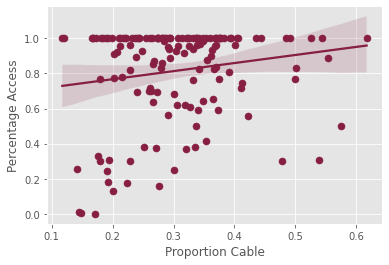

In [222]:
def plt_regression(x, y, data):
    reg_plot = sns.regplot(x=x, y=y, fit_reg=True, data=data, truncate=True, color="#861f41")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

plt_regression('Proportion Cable', 'Percentage Access', non_na.sample(150, random_state=1))

In [131]:
#Correlation Matrix
from sklearn import preprocessing
from scipy.stats.stats import pearsonr
from scipy.stats.stats import linregress

#scaler = preprocessing.MinMaxScaler()

#scaled = pd.DataFrame(scaler.fit_transform(non_na))

#scaled.columns = non_na.columns

correlation = non_na.corr()

access_corr = correlation['Access']#.sort_values()

access_corr

Percentage Access                   0.835044
Access                              1.000000
Total                               0.122294
Total Male                          0.096221
Total Female                        0.140866
                                      ...   
Proportion High Earning Female      0.118847
Proportion High Earning Male        0.104242
Proportion No Computer             -0.164895
Proportion Dialup                  -0.100435
Proportion One or more computers    0.077568
Name: Access, Length: 238, dtype: float64

In [132]:
pct_corr = correlation['Percentage Access']

In [133]:
pearsons_corr = []
for column in non_na:
    pearsons_corr.append(pearsonr(non_na['Access'], non_na[column]))

ols = []
for column in non_na:
    ols.append(linregress(non_na['Access'], non_na[column]))

pearsons_corr = pd.DataFrame(pearsons_corr)
ols = pd.DataFrame(ols)

pearsons_results = pd.DataFrame(non_na.columns).join(pearsons_corr, lsuffix='x')
ols_results = pd.DataFrame(non_na.columns).join(ols)


In [134]:
pearsons_corr_perc = []
for column in non_na:
    pearsons_corr_perc.append(pearsonr(non_na['Percentage Access'], non_na[column]))

ols_perc = []
for column in non_na:
    ols_perc.append(linregress(non_na['Percentage Access'], non_na[column]))

pearsons_corr_perc = pd.DataFrame(pearsons_corr_perc)
ols_perc = pd.DataFrame(ols_perc)

pearsons_perc_results = pd.DataFrame(non_na.columns).join(pearsons_corr_perc, lsuffix='x')
ols_perc_results = pd.DataFrame(non_na.columns).join(ols_perc)


In [135]:
access_set = non_na[non_na['Access'] == 1]

noaccess_set = non_na[non_na['Access'] == 0]

In [136]:
#OLS Regression Implementation
import statsmodels.api as sm

Y = non_na['Percentage Access']
X = non_na.loc[:, ['Agriculture, forestry, fishing, hunting, mining','Arts, entertainment, and recreation, and accommodation and food services', 'Cable, fiberoptic or DSL']]


model = sm.OLS(Y,X)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      Percentage Access   R-squared (uncentered):                   0.791
Model:                            OLS   Adj. R-squared (uncentered):              0.791
Method:                 Least Squares   F-statistic:                          7.696e+04
Date:                Thu, 21 Apr 2022   Prob (F-statistic):                        0.00
Time:                        15:01:32   Log-Likelihood:                         -32190.
No. Observations:               60981   AIC:                                  6.439e+04
Df Residuals:                   60978   BIC:                                  6.441e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
============================================================================================================================================
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------
Agriculture, forestry, fishing, hunting, mining                              0.0006   2.36e-05     26.031      0.000       0.001       0.001
Arts, entertainment, and recreation, and accommodation and food services     0.0008   1.38e-05     58.067      0.000       0.001       0.001
Cable, fiberoptic or DSL                                                     0.0005   2.61e-06    204.051      0.000       0.001       0.001
==============================================================================
Omnibus:                     4195.008   Durbin-Watson:                   1.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5623.534
Skew:                          -0.615   Prob(JB):                         0.00
Kurtosis:                       3.837   Cond. No.                         17.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

https://www.researchgate.net/post/What_is_the_minimum_value_of_correlation_coefficient_to_prove_the_existence_of_the_accepted_relationship_between_scores_of_two_of_more_tests

https://realpython.com/numpy-scipy-pandas-correlation-python/

T Test on mean
https://stackoverflow.com/questions/43292885/how-to-perform-a-t-test-on-data-stored-in-a-pandas-dataframe

Median Test


https://www.kaggle.com/code/omkardhudi/hypothesis-testing-in-python/notebook


In [137]:
#Split out blocks without access and analyze
access = non_na[non_na['Access'] == 1]

no_access = non_na[non_na['Access'] == 0]

from scipy.stats import ttest_ind
from scipy.stats import kruskal

median_comparison = pd.concat([pd.DataFrame(access.median()), pd.DataFrame(no_access.median())], axis=1, ignore_index=True)
mean_comparison = pd.concat([pd.DataFrame(access.mean()), pd.DataFrame(no_access.mean())], axis=1, ignore_index=True)

tt = ttest_ind(access, no_access)
mt = kruskal(access, no_access)

mean_comparison['t statistic'] = tt[0]
mean_comparison['p value'] = np.asarray(np.round(np.array(tt[1]),8), dtype = np.float64, order ='C')

median_comparison['h statistic'] = mt[0]
median_comparison['p value'] = np.asarray(np.round(np.array(mt[1]),8), dtype = np.float64, order ='C')

outlier_mean = mean_comparison[mean_comparison['p value'] >= 0.01]
outlier_median = median_comparison[median_comparison['p value'] >= 0.01]

mean_comparison = mean_comparison[mean_comparison['p value'] < 0.001]
median_comparison = median_comparison[median_comparison['p value'] < 0.01]


In [190]:
mean_comparison[mean_comparison.index == 'Six figure household income'][0][0]

386.3690151528834

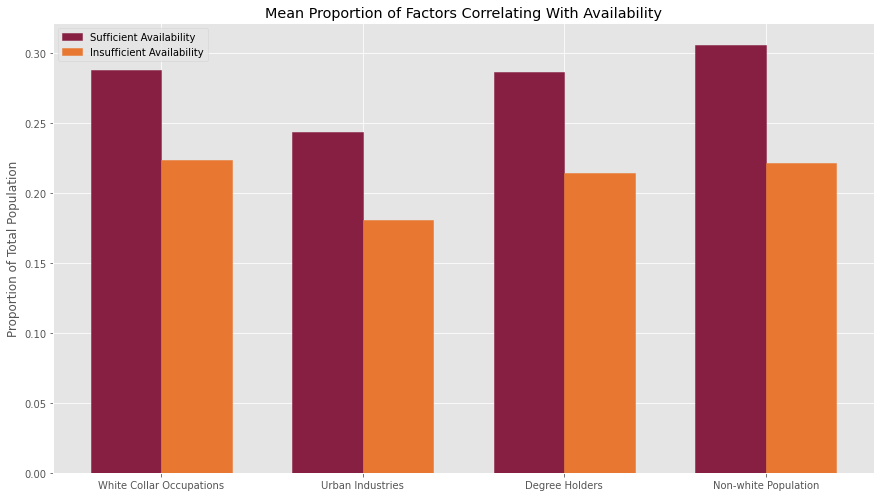

In [218]:
plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(14.7, 8.27)

X = ['White Collar Occupations', 'Urban Industries', 'Degree Holders', 'Non-white Population']
Y_1 = [mean_comparison[mean_comparison.index == 'White Collar Occupation'][0][0]/mean_comparison[mean_comparison.index == 'Total'][0][0],mean_comparison[mean_comparison.index == 'Urban Industry'][0][0]/mean_comparison[mean_comparison.index == 'Total'][0][0],mean_comparison[mean_comparison.index == 'Degree holders'][0][0]/mean_comparison[mean_comparison.index == 'Total'][0][0],mean_comparison[mean_comparison.index == 'Non-white'][0][0]/mean_comparison[mean_comparison.index == 'Total'][0][0]]
Y_2 = [mean_comparison[mean_comparison.index == 'White Collar Occupation'][1][0]/mean_comparison[mean_comparison.index == 'Total'][1][0],mean_comparison[mean_comparison.index == 'Urban Industry'][1][0]/mean_comparison[mean_comparison.index == 'Total'][1][0],mean_comparison[mean_comparison.index == 'Degree holders'][1][0]/mean_comparison[mean_comparison.index == 'Total'][1][0],mean_comparison[mean_comparison.index == 'Non-white'][1][0]/mean_comparison[mean_comparison.index == 'Total'][1][0]]
ind = np.arange(len(X)) 

width = 0.35       
bars = plt.bar(ind, Y_1, width, label='Sufficient Availability')       
bars2 = plt.bar(ind + width, Y_2, width, label='Insufficient Availability')

bars[0].set_color('#861f41')
bars[1].set_color('#861f41')
bars[2].set_color('#861f41')
bars[3].set_color('#861f41')
bars2[0].set_color('#e87731')
bars2[1].set_color('#e87731')
bars2[2].set_color('#e87731')
bars2[3].set_color('#e87731')

plt.ylabel('Proportion of Total Population')
#plt.xlabel('Education Level')
plt.title('Mean Proportion of Factors Correlating With Availability')

plt.xticks(ind + width / 2, ('White Collar Occupations', 'Urban Industries', 'Degree Holders', 'Non-white Population'))
plt.legend(loc='best')
plt.show()

In [165]:
mean_comparison[mean_comparison.index == 'Total'][[0,1]].values[0]

array([4065.76060612, 3375.46097648])

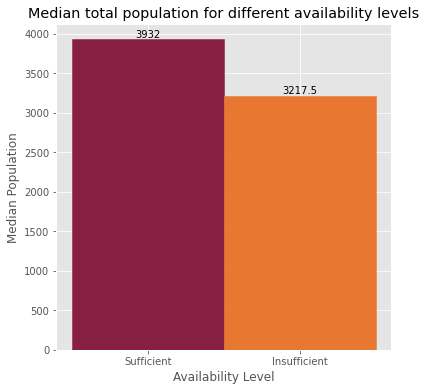

In [212]:
# draw the bar chart of the data.
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

X = [17, 19]
ind = np.arange(len(X)) 

width = 1      
bars = plt.bar(ind, median_comparison[median_comparison.index == 'Total'][[0,1]].values[0], width)
#plt.bar(ind + width, laptop_access5, width, label='laptop affordable rate')

bars[0].set_color('#861f41')
bars[1].set_color('#e87731')

#plt.ylim((0.4, 1))
plt.ylabel('Median Population')
plt.xlabel('Availability Level')
plt.title('Median total population for different availability levels')
ax.bar_label(ax.containers[0], label_type='edge')

plt.xticks(ind,  ('Sufficient', 'Insufficient'))

#plt.legend(loc='best')
plt.show()

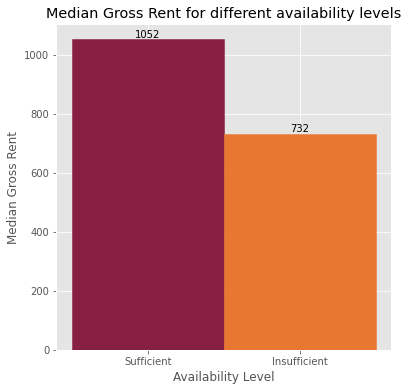

In [220]:
# draw the bar chart of the data.
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

X = [17, 19]
ind = np.arange(len(X)) 

width = 1       
bars = plt.bar(ind, median_comparison[median_comparison.index == 'Median gross rent'][[0,1]].values[0], width)
#plt.bar(ind + width, laptop_access5, width, label='laptop affordable rate')

bars[0].set_color('#861f41')
bars[1].set_color('#e87731')
ax.bar_label(ax.containers[0], label_type='edge')

#plt.ylim((0.4, 1))
plt.ylabel('Median Gross Rent')
plt.xlabel('Availability Level')
plt.title('Median Gross Rent for different availability levels')

plt.xticks(ind,  ('Sufficient', 'Insufficient'))

#plt.legend(loc='best')
plt.show()

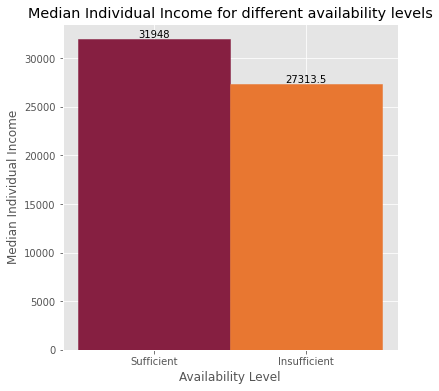

In [219]:
# draw the bar chart of the data.
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

X = [17, 19]
ind = np.arange(len(X)) 

width = 1         
bars = plt.bar(ind, median_comparison[median_comparison.index == 'Median individual income (12mo)'][[0,1]].values[0], width)
#plt.bar(ind + width, laptop_access5, width, label='laptop affordable rate')

bars[0].set_color('#861f41')
bars[1].set_color('#e87731')

ax.bar_label(ax.containers[0], label_type='edge')
#plt.ylim((0.4, 1))
plt.ylabel('Median Individual Income')
plt.xlabel('Availability Level')
plt.title('Median Individual Income for different availability levels')

plt.xticks(ind,  ('Sufficient', 'Insufficient'))

#plt.legend(loc='best')
plt.show()

In [141]:
no_access.describe()

,Percentage Access,Access,Total,Total Male,Total Female,Median Age,Median Age Male,Median Age Female,18 to 29 years,30 to 44 years,...,Urban Industry,Proportion Urban Industry,Proportion Nonwhite,Proportion Citizen,Proportion Non-Citizen,Proportion High Earning Female,Proportion High Earning Male,Proportion No Computer,Proportion Dialup,Proportion One or more computers
count,5612.000000,5612.0,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,...,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000
mean,0.205557,0.0,3375.460976,1717.483428,1657.977548,42.786725,41.683393,43.591322,493.796507,552.298468,...,609.009088,0.176773,0.219177,0.973017,0.026983,0.018018,0.055163,0.051842,0.002030,0.331565
std,0.172375,0.0,1523.731380,833.211017,776.728259,8.403319,8.975212,9.296738,490.707366,327.147855,...,389.495376,0.066898,0.237567,0.051945,0.051945,0.028692,0.056754,0.038472,0.003697,0.080382
min,0.000000,0.0,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.038971,0.0,2269.000000,1127.000000,1104.000000,37.900000,36.400000,38.600000,261.750000,329.000000,...,347.000000,0.136374,0.045984,0.972664,0.001425,0.001206,0.020477,0.027726,0.000000,0.301052
50%,0.181818,0.0,3217.500000,1610.500000,1578.000000,42.850000,41.700000,44.100000,404.000000,498.000000,...,529.000000,0.169189,0.123990,0.991677,0.008323,0.009021,0.039514,0.046703,0.000000,0.338988
75%,0.341906,0.0,4291.000000,2170.250000,2137.000000,47.900000,47.100000,49.400000,592.000000,709.000000,...,777.000000,0.210511,0.311265,0.998575,0.027336,0.021766,0.069397,0.069177,0.002986,0.372770
max,0.753086,0.0,17213.000000,8800.000000,9694.000000,89.200000,89.400000,89.300000,11640.000000,3317.000000,...,5075.000000,1.000000,1.000000,1.000000,0.882353,0.472222,1.000000,1.000000,0.083176,1.000000


In [142]:
access.describe()

,Percentage Access,Access,Total,Total Male,Total Female,Median Age,Median Age Male,Median Age Female,18 to 29 years,30 to 44 years,...,Urban Industry,Proportion Urban Industry,Proportion Nonwhite,Proportion Citizen,Proportion Non-Citizen,Proportion High Earning Female,Proportion High Earning Male,Proportion No Computer,Proportion Dialup,Proportion One or more computers
count,55369.000000,55369.0,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,...,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000
mean,0.928400,1.0,4065.760606,1994.793711,2070.966895,39.627385,38.339399,40.847534,619.949412,686.645072,...,988.878849,0.241633,0.308367,0.935293,0.064707,0.036565,0.086636,0.034191,0.001085,0.351494
std,0.133654,0.0,1628.823823,828.835126,845.100761,7.906528,8.163151,8.525527,468.996372,349.356030,...,516.314912,0.077648,0.258008,0.077725,0.077725,0.046113,0.089282,0.029595,0.002583,0.073373
min,0.088235,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.913043,1.0,2867.000000,1394.000000,1452.000000,34.400000,33.000000,35.100000,359.000000,439.000000,...,608.000000,0.187983,0.101485,0.909204,0.010486,0.005627,0.022289,0.013049,0.000000,0.310467
50%,1.000000,1.0,3932.000000,1918.000000,2000.000000,39.200000,37.900000,40.600000,536.000000,637.000000,...,912.000000,0.235813,0.230066,0.965525,0.034475,0.019674,0.055419,0.027248,0.000000,0.350377
75%,1.000000,1.0,5104.000000,2503.000000,2603.000000,44.500000,43.200000,46.300000,765.000000,875.000000,...,1285.000000,0.287120,0.450682,0.989514,0.090796,0.050202,0.122342,0.047571,0.001587,0.390105
max,1.000000,1.0,39373.000000,27204.000000,12169.000000,85.100000,85.900000,85.000000,22998.000000,5664.000000,...,6266.000000,1.000000,1.000000,1.000000,1.000000,0.666667,1.000000,1.000000,0.160000,1.000000
